In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.cluster import *

In [2]:
file_path = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/ScatterData_Mokal_MK014.csv'

In [3]:
data_set = pd.read_csv('/home/mytrah-pc/Mytrah_Adithya/data_turbine/ScatterData_Pottipadu_PPD01.csv')

def process_dbscan(data_set, dict_params_dbscan, scale_factor_wind_speed=4.0/3, scale_factor_active_power=1):

    # Only take the required data, only positive power points
    required_data = data_set[data_set['ActivePower'] > 0.08][['ActivePower', 'WindSpeed', 'Timestamp']].copy()

    # Get some params
    max_wind_speed = required_data['WindSpeed'].max()
    min_wind_speed = required_data['WindSpeed'].min()
    max_active_power = required_data['ActivePower'].max()
    min_active_power = required_data['ActivePower'].min()
    normalization_factor_wind_speed = max_wind_speed - min_wind_speed
    normalization_factor_active_power = max_active_power - min_active_power

    # Add some columns to required data
    required_data['ScaledWindSpeed'] = ((required_data['WindSpeed'] - min_wind_speed) * scale_factor_wind_speed) \
                                        / normalization_factor_wind_speed
    required_data['ScaledActivePower'] = ((required_data['ActivePower'] - min_active_power) * scale_factor_active_power) \
                                        / normalization_factor_active_power
    
    # Cluster default Number
    required_data['cluster_number'] = -2
    
    # Clustring Algorithm
    clustering_algorithm = DBSCAN(**dict_params_dbscan)
    
    # run the algorithm
    required_data['cluster_number'] = clustering_algorithm.fit_predict(required_data[['ScaledWindSpeed', \
                                                                                      'ScaledActivePower']])

    return required_data.copy()
    
def curve_filter(data_set, return_columns, push_down_value, curve_straighten_value, push_right_value):

    # Find the cluster with max number of elements
    max_elements_cluster_number = -2
    max_elements = 0
    for group in data_set.groupby('cluster_number'):
        if(group[1].shape[0] > max_elements):
            max_elements = group[1].shape[0]
            max_elements_cluster_number = group[0]

    
    # define limits
    scales_active_power_limits = (0.03, 0.97)
    
    # Apply some filters to get the required
    global_high_cluster = data_set[data_set['ScaledActivePower'] > 0.99]   
    max_elements_cluster = data_set[data_set['cluster_number'] == max_elements_cluster_number]
    filter_limits_active_power = max_elements_cluster[ \
                                    (max_elements_cluster['ScaledActivePower'] > scales_active_power_limits[0]) \
                                     & (max_elements_cluster['ScaledActivePower'] < scales_active_power_limits[1])]


    # Customised Sigmoid function for curve fitting
    def custom_sigmoid(x, a, b):
        return 1/(1 + np.exp(-a * x + b))
    
    optimize_on = pd.concat([filter_limits_active_power, global_high_cluster])
    
    params_optimal, params_covariance = curve_fit(custom_sigmoid, optimize_on['ScaledWindSpeed'], \
                                                  optimize_on['ScaledActivePower'])
    
    ################################### Filter elements below the Curve ############################
    filtered_data = data_set[data_set['ScaledActivePower'] < (custom_sigmoid(data_set['ScaledWindSpeed'], \
                                                                        params_optimal[0] + curve_straighten_value, \
                                                                        params_optimal[1] + push_right_value) \
                                                                        - push_down_value)]
    
    points_below_the_curve = filtered_data[return_columns].copy()
    
    return points_below_the_curve
    

In [4]:
points_below_curve = curve_filter(
    process_dbscan(
        data_set=data_set,
        dict_params_dbscan={
            'eps': 0.3/20,
            'min_samples': 15
        },
        scale_factor_wind_speed=4.0/3,
        scale_factor_active_power=1
    ),
    return_columns=['ActivePower', 'WindSpeed', 'Timestamp', 'ScaledActivePower'],
    push_down_value=0.1,
    curve_straighten_value=0,
    push_right_value=0.07
)

points_below_curve = points_below_curve[points_below_curve['ScaledActivePower'] > 0.2]

# possible_curtailments = points_below_curve.copy()

possible_curtailments = process_dbscan(
    data_set=points_below_curve,
    dict_params_dbscan={
        'eps': 0.03,
        'min_samples': 15
    },
    scale_factor_wind_speed=0.01,
    scale_factor_active_power=1
)

threshold_value = 11

def rounding_method(number):
    multiply_factor = 100
    int_format = int(number * multiply_factor)
    round_off_by_factor = 2
    delta = int_format % round_off_by_factor
    return int_format + round_off_by_factor - delta


possible_curtailments['curtailment_indexer'] = possible_curtailments['ScaledActivePower'].apply(rounding_method)

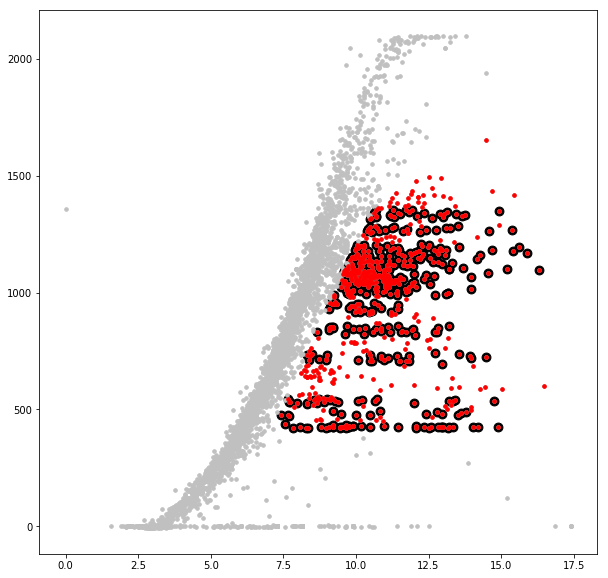

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for group in possible_curtailments.groupby('curtailment_indexer'):
    if group[1].shape[0] > threshold_value:
        plt.scatter(
            group[1]['WindSpeed'],
            group[1]['ActivePower'],
            s=np.pi*5*5,
            c='#000000'
        )

plt.scatter(
    data_set['WindSpeed'],
    data_set['ActivePower'],
    s=np.pi*2*2,
    c='#c0c0c0'
)

plt.scatter(
    points_below_curve['WindSpeed'],
    points_below_curve['ActivePower'],
    s=np.pi*2*2,
    c='red'
)

plt.show()

ScatterData_Kaladonger_KD29.csv


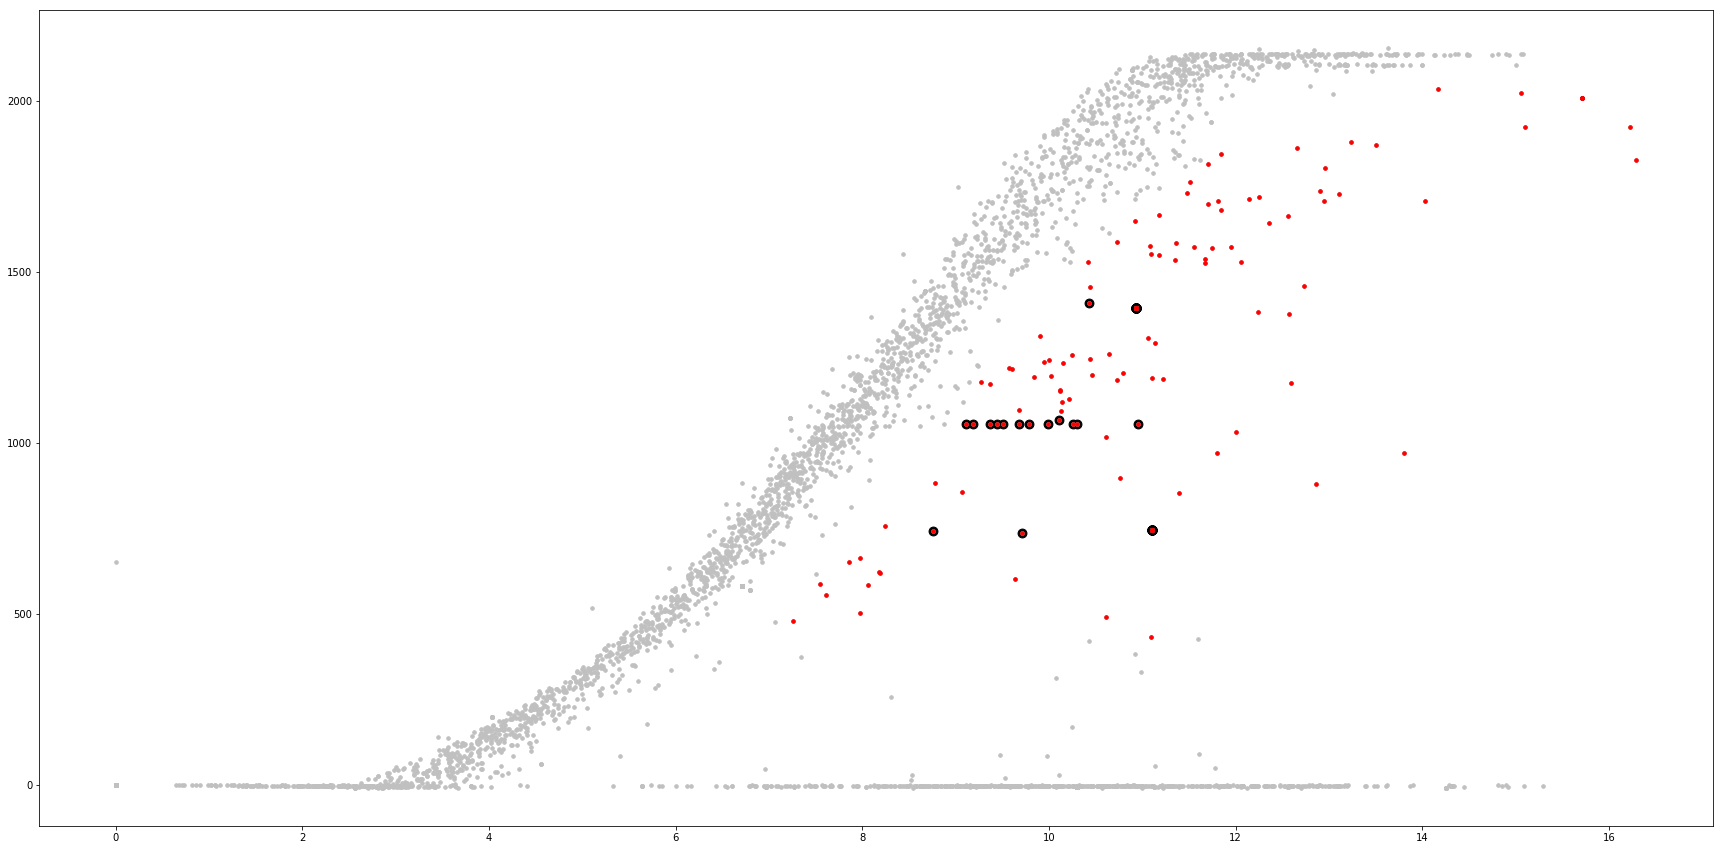

ScatterData_Kaladonger_KD07.csv


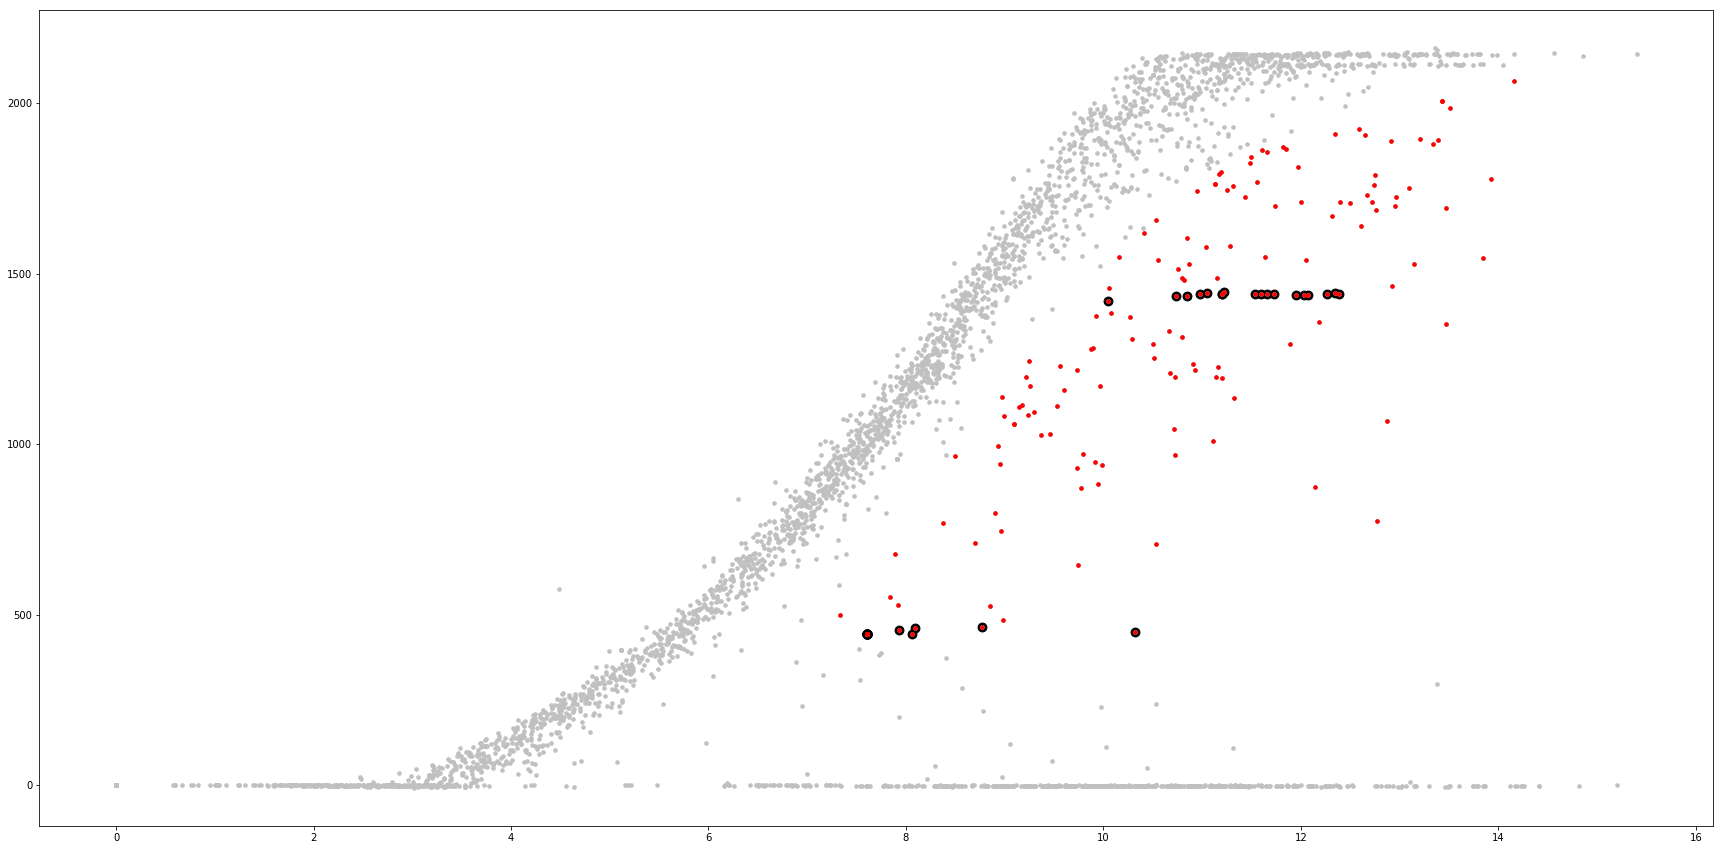

ScatterData_Mokal_MK066.csv


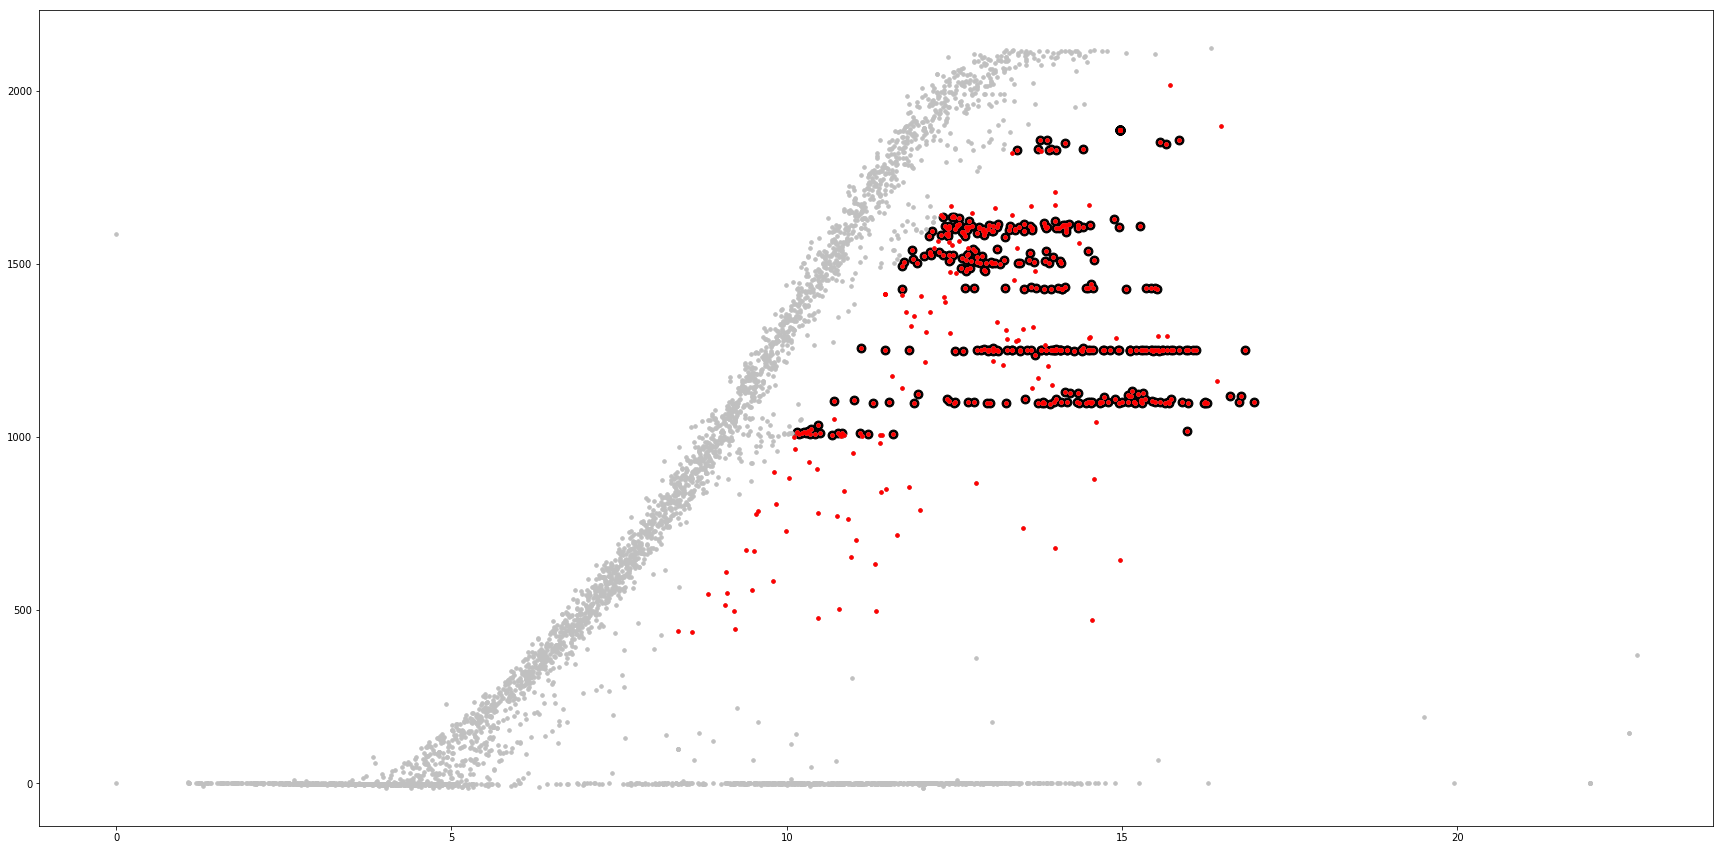

ScatterData_Mokal_MK014.csv


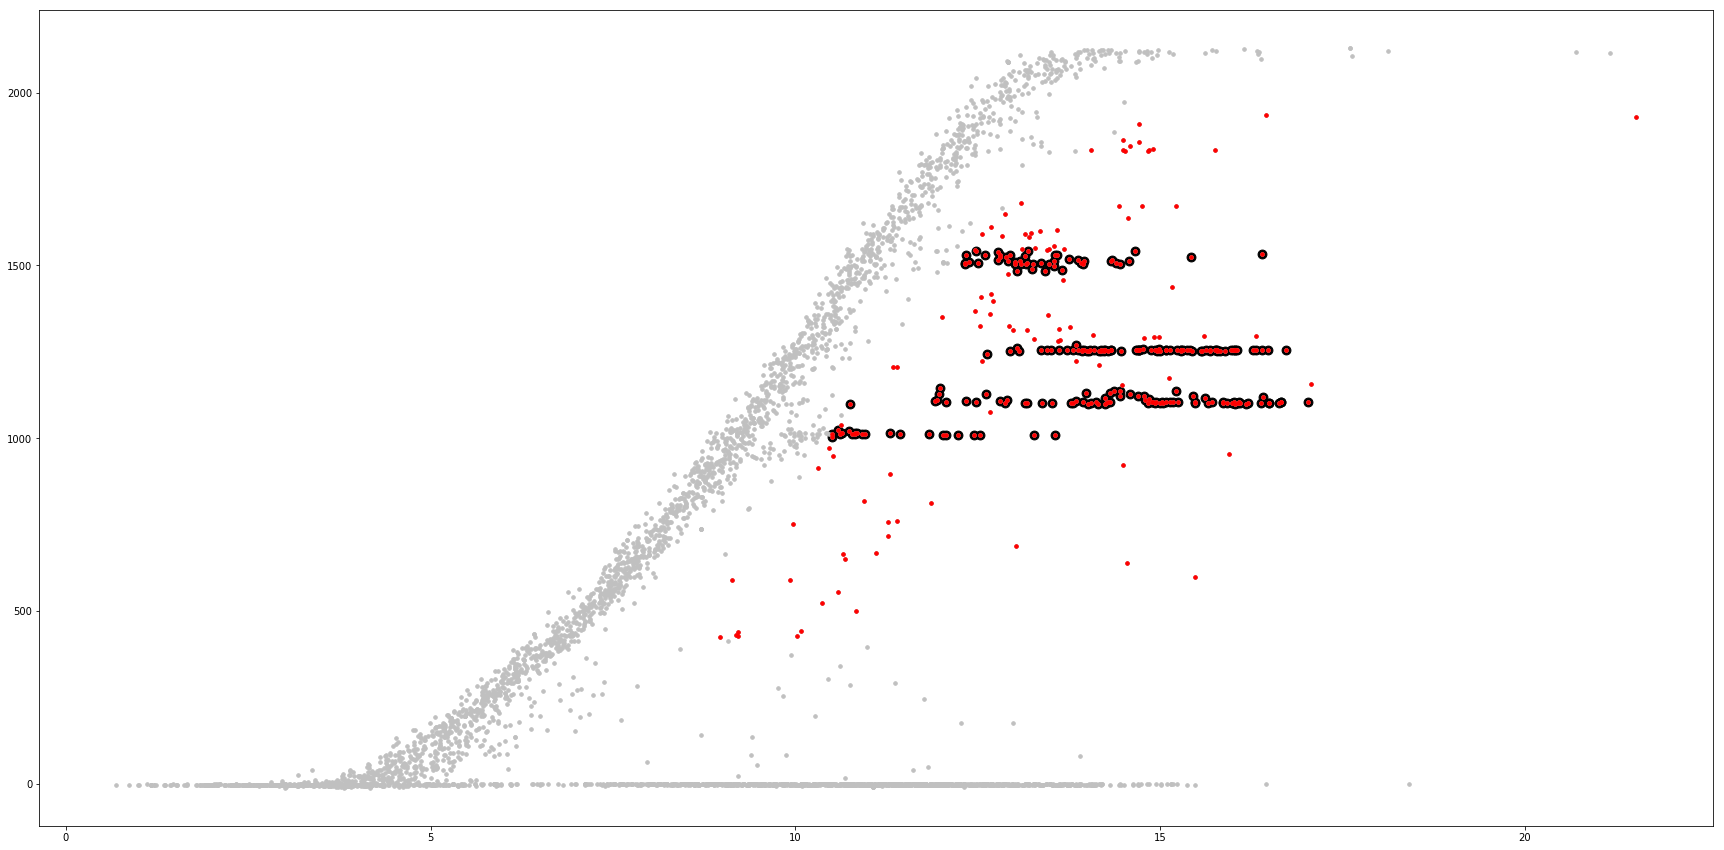

ScatterData_Nidhi_NDH-047.csv


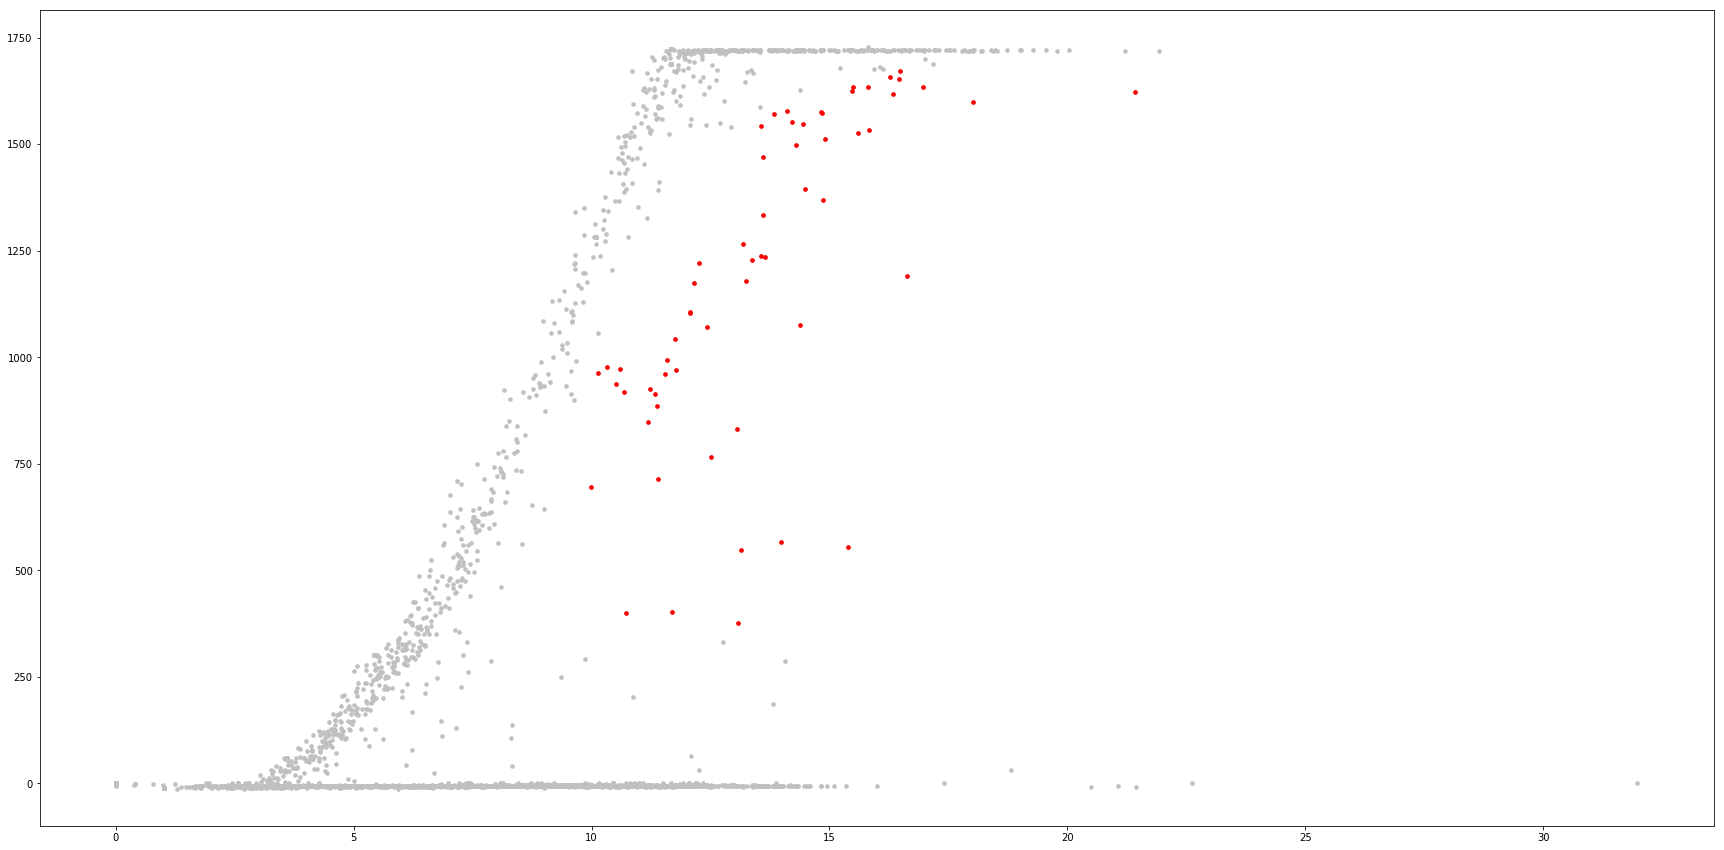

ScatterData_Mahidad_JSD38.csv


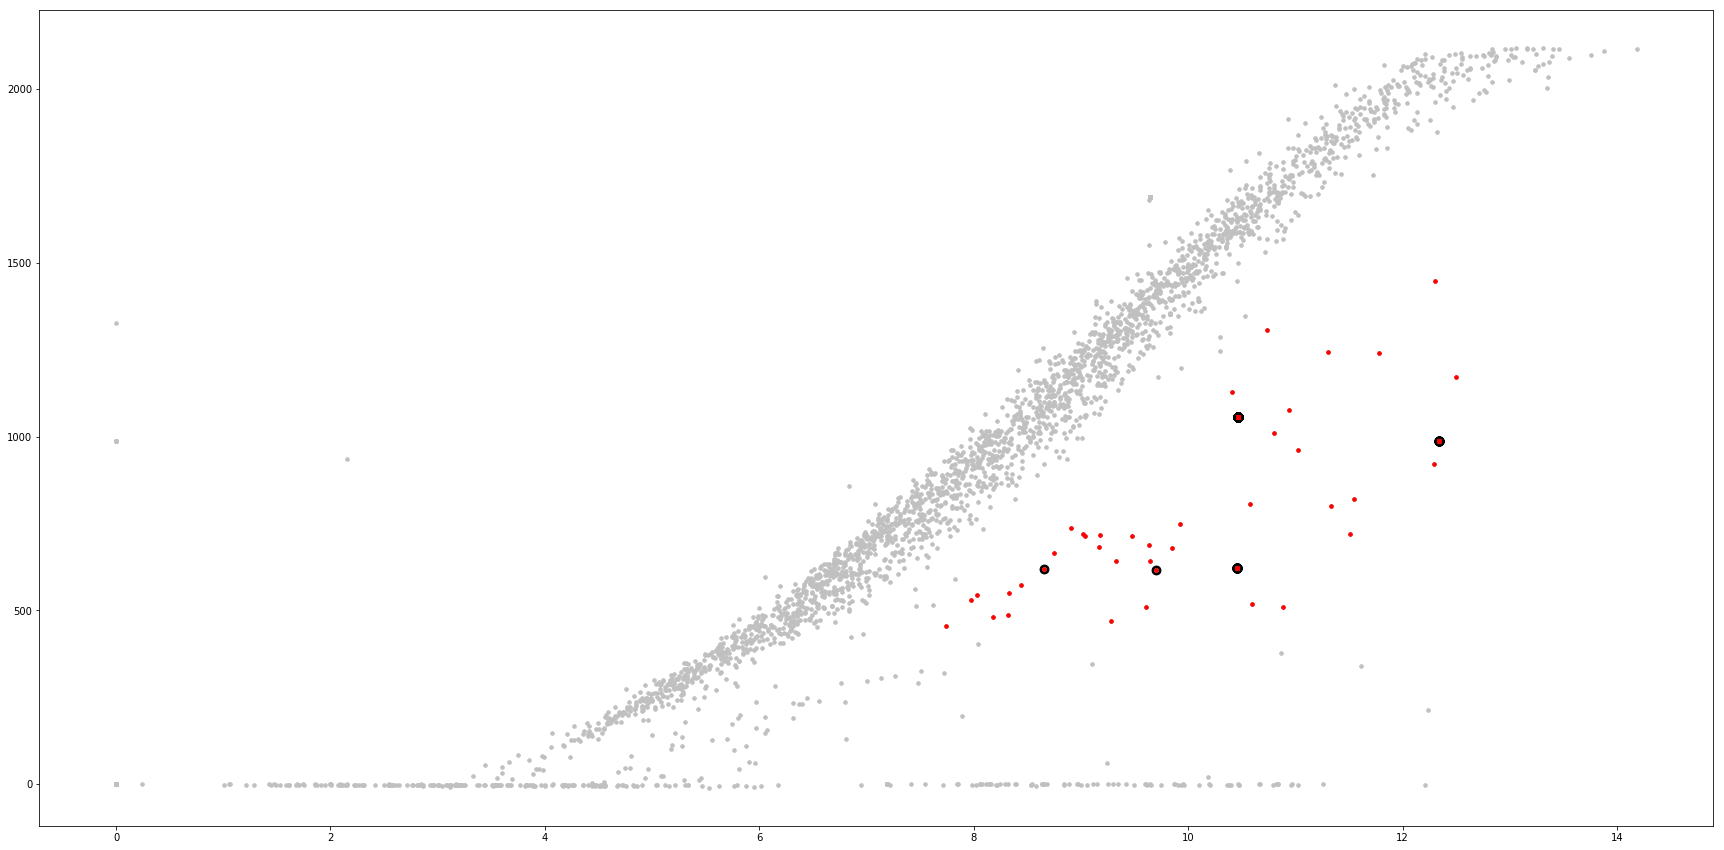

ScatterData_Pottipadu_PPD01.csv


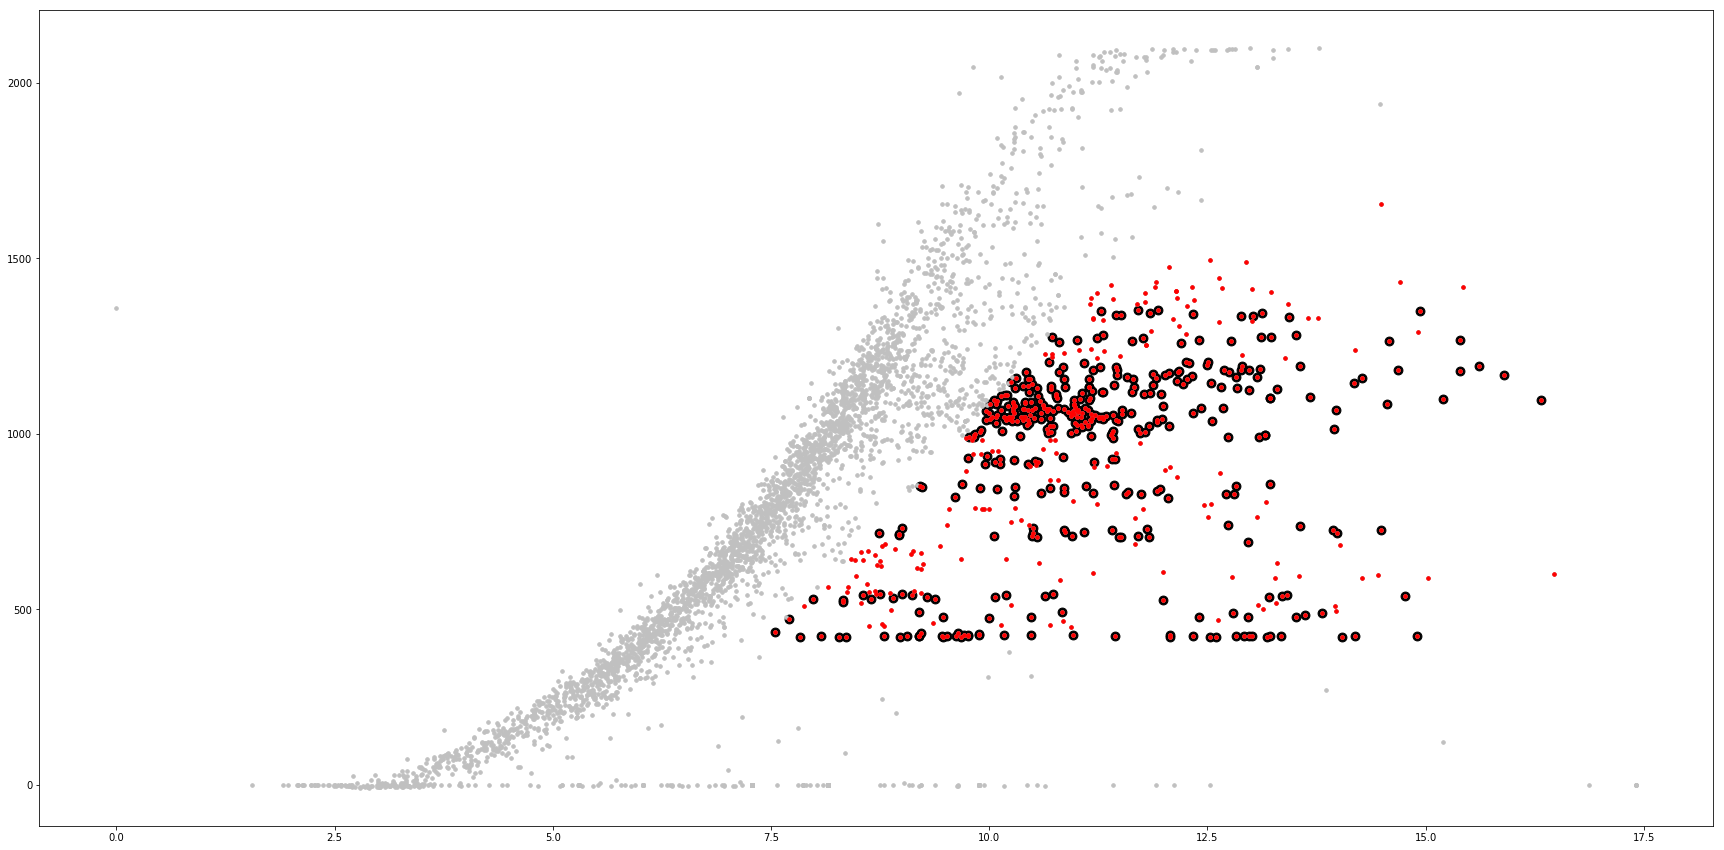

refcrv_testing.csv


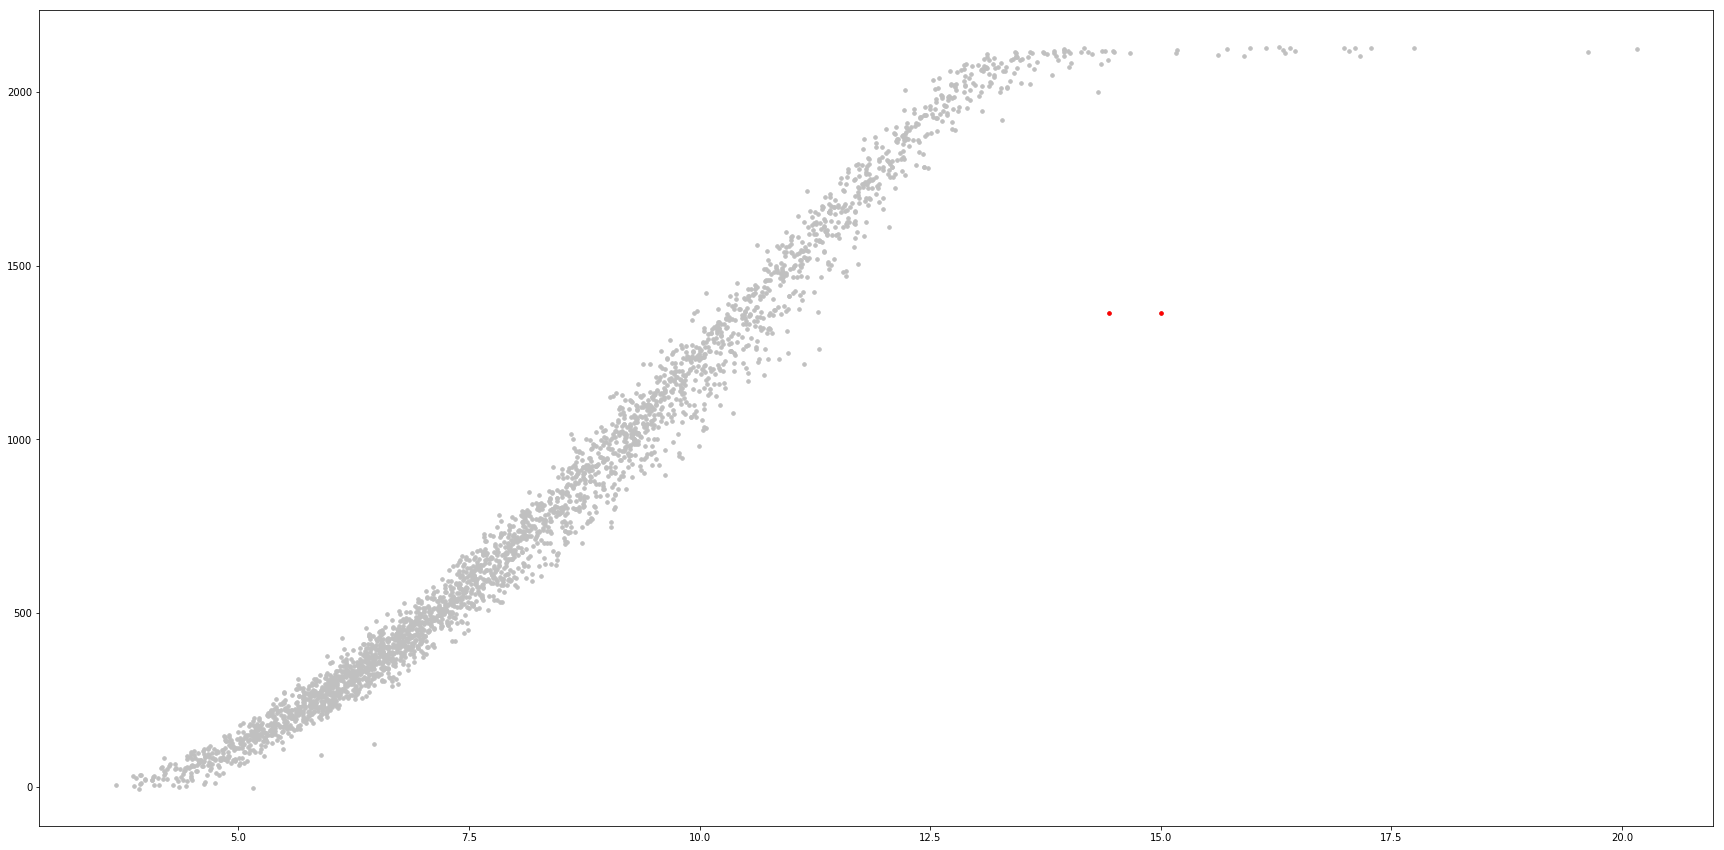

ScatterData_Nidhi_NDH-022.csv


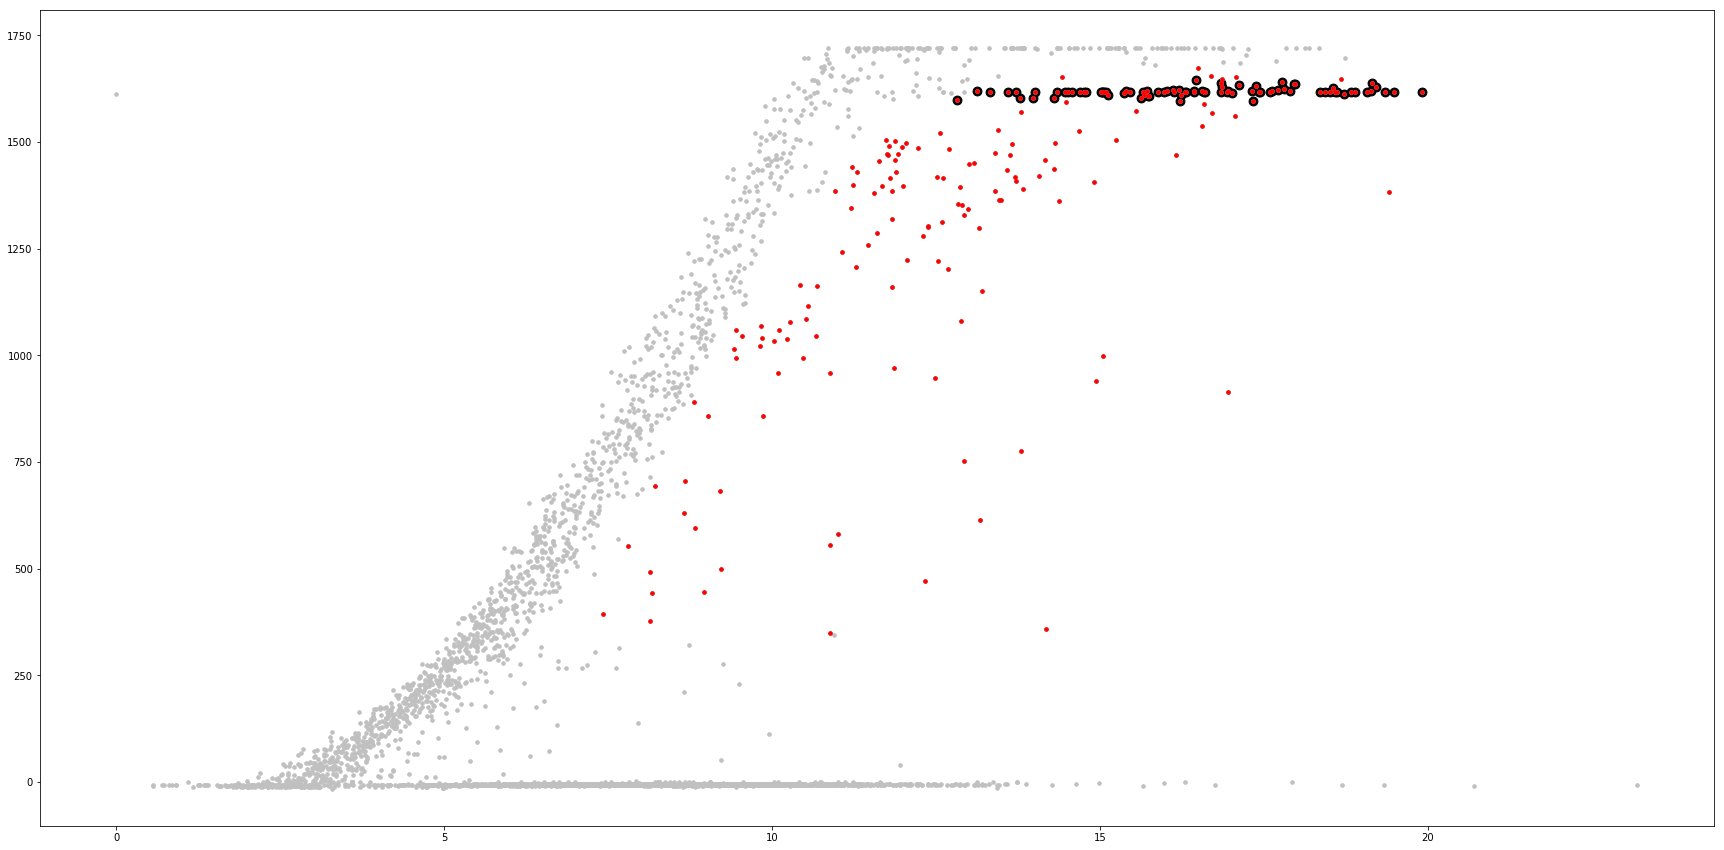

ScatterData_Chakla_C66.csv


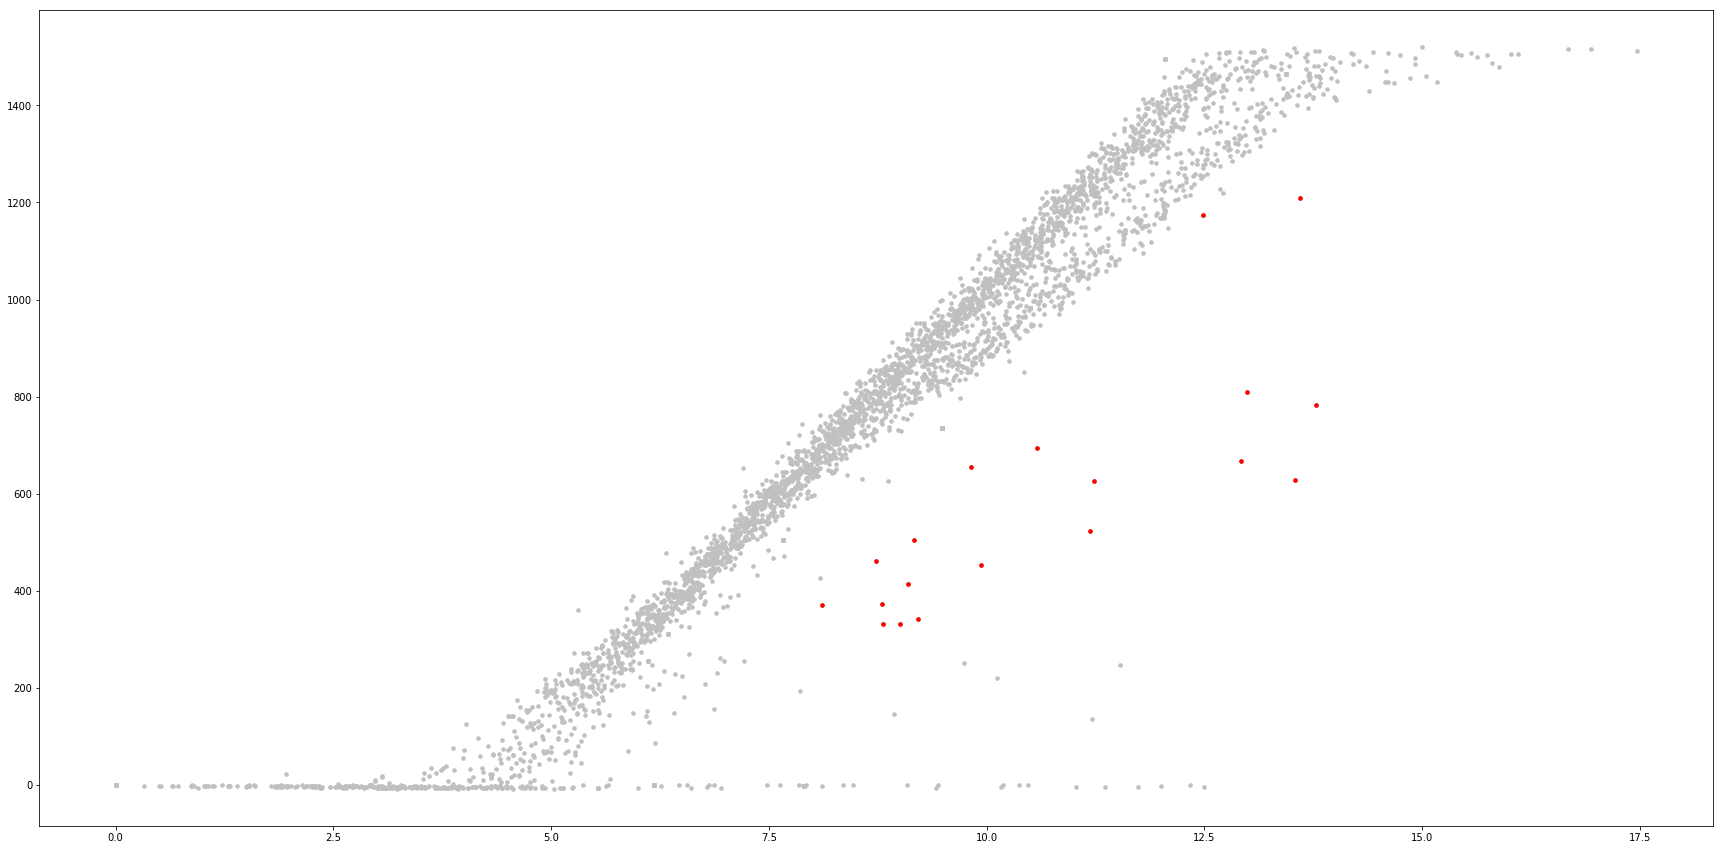

dt


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [6]:
from os import listdir
from os.path import isfile, join

data_path = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/'
for f in listdir(data_path):
    print f
    import matplotlib.pyplot as plt
    plt.figure(figsize=(30,15))

    data_set = pd.read_csv(data_path + f)
    threshold_value = 10

    points_below_curve = curve_filter(
        process_dbscan(
            data_set=data_set,
            dict_params_dbscan={
                'eps': 0.3/20,
                'min_samples': 15
            },
            scale_factor_wind_speed=4.0/3,
            scale_factor_active_power=1
        ),
        return_columns=['ActivePower', 'WindSpeed', 'Timestamp', 'ScaledActivePower'],
        push_down_value=0.02,
        curve_straighten_value=0.07,
        push_right_value=0.7
    )

    points_below_curve = points_below_curve[points_below_curve['ScaledActivePower'] > 0.2]

    possible_curtailments = process_dbscan(
        data_set=points_below_curve,
        dict_params_dbscan={
            'eps': 0.03,
            'min_samples': 15
        },
        scale_factor_wind_speed=0.01,
        scale_factor_active_power=1
    )

    possible_curtailments['curtailment_indexer'] = possible_curtailments['ScaledActivePower'].apply(rounding_method)

    for group in possible_curtailments.groupby('curtailment_indexer'):
        if group[1].shape[0] > threshold_value:
            plt.scatter(
                group[1]['WindSpeed'],
                group[1]['ActivePower'],
                s=np.pi*5*5,
                c='#000000'
            )
    

    plt.scatter(
        data_set['WindSpeed'],
        data_set['ActivePower'],
        s=np.pi*2*2,
        c='#c0c0c0'
    )

    plt.scatter(
        points_below_curve[points_below_curve['ScaledActivePower'] > 0.2]['WindSpeed'],
        points_below_curve[points_below_curve['ScaledActivePower'] > 0.2]['ActivePower'],
        s=np.pi*2*2,
        c='red'
    )

    def custom_sigmoid(x, a, b):
        return 1/(1 + np.exp(-a * x + b))
    
   
    plt.show()